In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from sklearn.model_selection import train_test_split
from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.datasets import generate_synthetic_data


In [2]:
# set a few params
metric = "qini"
n_samples = 1000
test_size = 0.33 # equal train,val,test
components_time_budget = 60
time_budget = 60*5
estimator_list = "all"
n_runs = 1
out_dir = "../data/"
filename_out = "example_qini" 


In [3]:
dataset = generate_synthetic_data(n_samples=n_samples, confounding=False,noisy_outcomes=True)
data_df, features_X, features_W = preprocess_dataset(
    dataset.data, treatment=dataset.treatment, targets=dataset.outcomes
)
# drop true effect:
features_X = [f for f in features_X if f != "true_effect"]
print(f"features_X: {features_X}")
print(f"features_W: {features_W}")
data_df.head(10)



features_X: ['X1', 'X2', 'X3', 'X4', 'X5']
features_W: ['random']


,treatment,outcome,X1,X2,X3,X4,X5,true_effect,random
0,0.0,-0.730343,-0.089616,-0.364752,-1.206839,-0.703253,-0.597038,-1.631729,1.0
1,0.0,-1.125437,-0.387333,0.732643,-0.809214,0.057528,-0.503497,-0.532384,1.0
2,1.0,-0.952609,1.514450,-0.651498,-0.147044,-0.345888,-0.712699,-0.098608,0.0
3,0.0,0.553686,0.120946,-0.046567,0.523585,0.116983,-0.101334,0.371527,1.0
4,1.0,1.161534,0.000095,-0.262368,0.860384,-1.098878,-1.023239,-0.839882,1.0
5,0.0,-0.146715,0.930683,0.314194,-0.520309,0.956100,0.126464,1.064939,1.0
6,1.0,0.058262,-0.359373,-0.047916,0.356744,-0.538487,-0.884469,-0.784108,1.0
7,1.0,0.687728,-0.811254,0.151773,0.925533,-0.293708,-0.399644,-0.249768,0.0
8,1.0,-0.765021,-0.167011,-0.063589,-0.345830,0.021311,-0.276784,-0.426637,1.0
9,1.0,1.794513,0.525866,0.948743,0.478450,-0.272753,0.211376,0.915911,0.0


In [4]:


train_df, test_df = train_test_split(data_df, test_size=test_size)
test_df = test_df.reset_index(drop=True)


ac = AutoCausality(
    metric=metric,
    verbose=1,
    components_verbose=1,
    components_time_budget=components_time_budget,
    time_budget=time_budget,
    estimator_list=estimator_list,
    store_all_estimators=True,
)

ac.fit(
    train_df,
    treatment="treatment",
    outcome="outcome",
    common_causes=features_W,
    effect_modifiers=features_X,
)

# compute relevant scores (skip newdummy)
datasets = {"train": ac.train_df, "validation": ac.test_df, "test": test_df}
# get scores on train,val,test for each trial, 
# sort trials by validation set performance
# assign trials to estimators
estimator_scores = {est: [] for est in ac.scores.keys() if "NewDummy" not in est}
for trial in ac.results.trials:
    # estimator name:
    estimator_name = trial.last_result["estimator_name"]
    if  trial.last_result["estimator"]:
        estimator = trial.last_result["estimator"]
        scores = {}
        for ds_name, df in datasets.items():
            scores[ds_name] = {}
            # make scores
            est_scores = ac.scorer.make_scores(
                estimator,
                df,
                problem=ac.problem,
                metrics_to_report=ac.metrics_to_report,
            )

            # add cate:
            scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
            # add ground truth for convenience
            scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
            scores[ds_name][metric] = est_scores[metric]
        estimator_scores[estimator_name].append(scores)


# sort trials by validation performance
for k in estimator_scores.keys():
    estimator_scores[k] = sorted(
        estimator_scores[k],
        key=lambda x: x["validation"][metric],
        reverse=False if metric == "energy_distance" else True,
    )
results = {
    "best_estimator": ac.best_estimator,
    "best_config": ac.best_config,
    "best_score": ac.best_score,
    "optimised_metric": metric,
    "scores_per_estimator": estimator_scores,
}


with open(f"{out_dir}{filename_out}.pkl", "wb") as f:
    pickle.dump(results, f)




[flaml.tune.tune: 09-28 11:47:17] {335} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-28 11:47:17] {456} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.NewDummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.LinearDRLearner', 'fit_cate_intercept': 

[flaml.tune.tune: 09-28 11:47:29] {456} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.NewDummy'}}
[flaml.tune.tune: 09-28 11:47:40] {456} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 09-28 11:48:41] {456} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.TLearner'}}
[flaml.tune.tune: 09-28 11:50:41] {456} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


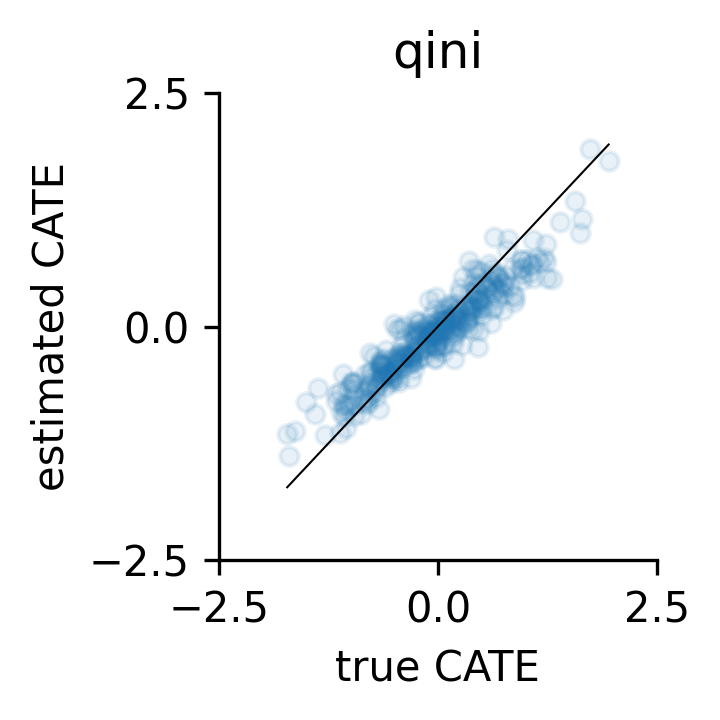

In [11]:
%matplotlib inline
f, ax = plt.subplots(1,1,figsize=(2.5,2.5),dpi=300)


# plot true against estimated for best estimator:

with open(f"{out_dir}{filename_out}.pkl","rb") as f:
    results = pickle.load(f)
CATE_gt = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_groundtruth"]
CATE_est = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_estimate"]


ax.scatter(CATE_gt,CATE_est,s=20,alpha=0.1)
ax.plot([min(CATE_gt),max(CATE_gt)],[min(CATE_gt),max(CATE_gt)],"k-",linewidth=0.5)
ax.set_xlabel("true CATE")
ax.set_ylabel("estimated CATE")
ax.set_title(f"{results['optimised_metric']}")
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
ax.set_xticks(np.arange(-2.5,2.51,2.5))
ax.set_yticks(np.arange(-2.5,2.51,2.5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout() 

now plot the score against the mse between estimated and true cate for each of the models in the scores dict

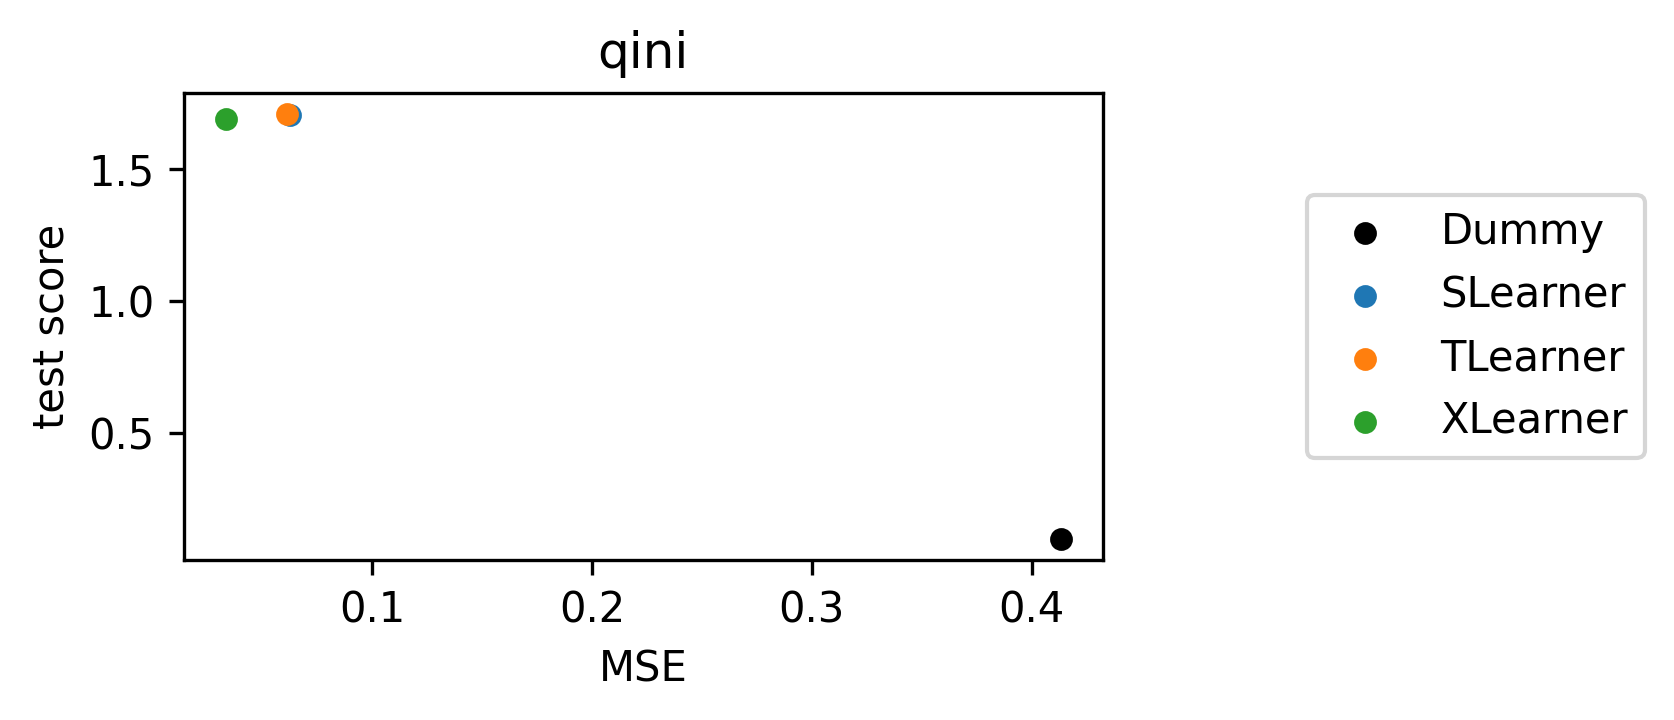

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

f, ax = plt.subplots(1,1,figsize=(6,2.5),dpi=300)

est_labels = []
sc = []

with open(f"{out_dir}{filename_out}.pkl","rb") as f:
    results = pickle.load(f)
    
ax.ticklabel_format(style="sci", useOffset=False)
for (est_name, scr), col in zip(results["scores_per_estimator"].items(),colors):                  
    if len(scr):
        # get score for best estimator:
        CATE_gt = scr[0]["test"]["CATE_groundtruth"]
        CATE_est = scr[0]["test"]["CATE_estimate"]
        mse=np.mean((CATE_gt-CATE_est)**2)
        score = scr[0]["test"][metric]
        sc.append(ax.scatter(mse,score,color=col,s=20))            
        est_labels.append(est_name.split(".")[-1])
        # also plot intermediate runs:
        if len(scr) > 1:
            print(f"{est_name}: {len(scr)} intermediate runs ")
            for i_run in range(1,len(scr)):
                CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
                CATE_est = scr[i_run]["test"]["CATE_estimate"]
                mse=np.mean((CATE_gt-CATE_est)**2)
                score = scr[i_run]["test"][metric]
                ax.scatter(mse,score,color=(0.8,0.8,0.8),s=20)
ax.set_xlabel("MSE")
ax.set_ylabel("test score")
ax.set_title(metric)
ax.legend(sc,est_labels,loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.tight_layout()
